In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from dataset import CarDamageDataset

In [2]:


datasets = [
    "C:/Users/taimo/projects/work/CarDefect/data/raw/dataset1", 
    "C:/Users/taimo/projects/work/CarDefect/data/raw/dataset2", 
    "C:/Users/taimo/projects/work/CarDefect/data/raw/dataset3", 
    "C:/Users/taimo/projects/work/CarDefect/data/raw/dataset4", 
    "C:/Users/taimo/projects/work/CarDefect/data/raw/dataset5", 
    "C:/Users/taimo/projects/work/CarDefect/data/raw/dataset6"
]

splits = ["train", "valid", "test"]

print("Starting robust merge process...")

for split in splits:
    merged_df = pd.DataFrame()
    print(f"\nProcessing '{split}' split...")
    
    for ds in datasets:
        ds_name = os.path.basename(ds)
        csv_path = os.path.join(ds, split, f"{split}.csv")
        
        if os.path.exists(csv_path):
            # 1. Read without assumptions first
            df = pd.read_csv(csv_path)
            
            # 2. Clean Column Names (Strip spaces)
            df.columns = [c.strip() for c in df.columns]
            
            # 3. Handle the "Duplicate Column" issue (Unnamed index)
            # If the first column is the old index (0, 1, 2...), drop it.
            if 'Unnamed: 0' in df.columns:
                df.drop(columns=['Unnamed: 0'], inplace=True)
                
            # 4. Find the 'filename' column (Case-insensitive check)
            # This fixes issues if it's named "Filename", "FILE_NAME", etc.
            found_col = False
            for col in df.columns:
                if col.lower() in ['filename', 'file name', 'image', 'id']:
                    df.rename(columns={col: 'filename'}, inplace=True)
                    found_col = True
                    break
            
            if not found_col:
                print(f"  ERROR: Could not find 'filename' column in {ds_name}/{split}")
                print(f"  Columns found: {df.columns.tolist()}")
                continue # Skip this file to avoid crashing
            
            # 5. Create absolute paths & prefix filenames (Your request)
            df['image_path'] = df['filename'].apply(lambda x: os.path.join(ds, split, x))
            df['filename'] = ds_name + "_" + df['filename']
            
            merged_df = pd.concat([merged_df, df], ignore_index=True)
            print(f"  -> Loaded {len(df)} images from {ds_name}")

    output_filename = f"merged_{split}.csv"
    merged_df.to_csv(f"../data/processed/{output_filename}", index=False)
    print(f"Saved {output_filename} (Total: {len(merged_df)})")

Starting robust merge process...

Processing 'train' split...
  -> Loaded 6085 images from dataset1
  -> Loaded 4210 images from dataset2
  -> Loaded 4210 images from dataset3
  -> Loaded 2105 images from dataset4
  -> Loaded 2105 images from dataset5
  -> Loaded 6127 images from dataset6
Saved merged_train.csv (Total: 24842)

Processing 'valid' split...
  -> Loaded 572 images from dataset1
  -> Loaded 574 images from dataset2
  -> Loaded 574 images from dataset3
  -> Loaded 574 images from dataset4
  -> Loaded 574 images from dataset5
  -> Loaded 574 images from dataset6
Saved merged_valid.csv (Total: 3442)

Processing 'test' split...
  -> Loaded 320 images from dataset1
  -> Loaded 322 images from dataset2
  -> Loaded 322 images from dataset3
  -> Loaded 322 images from dataset4
  -> Loaded 322 images from dataset5
  -> Loaded 322 images from dataset6
Saved merged_test.csv (Total: 1930)


# Car Defect Detection — Multi-Label Classification
This notebook trains a **ConvNeXt-Tiny model** to detect **multiple defects** on car images.

**Dataset:**
- Merged from 4 datasets (~30k images)
- CSVs: `merged_train.csv`, `merged_valid.csv`, `merged_test.csv`
- Each image can have multiple defects (`broken_glass`, `dent`, `scratch`, `wreck`)
- Images are resized from 640×640 → 224×224 for ConvNeXt

**Goal:**
- Multi-label classification using `BCEWithLogitsLoss`
- Flexible for GPU (RTX 4050) with mixed precision
- Class imbalance handled
- Grad-CAM visualization for explainability


In [3]:
# Mixed precision
from torch.cuda.amp import GradScaler, autocast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
# Load the CSVs you just created into variables
train_df = pd.read_csv("../data/processed/merged_train.csv")
val_df = pd.read_csv("../data/processed/merged_valid.csv")
test_df = pd.read_csv("../data/processed/merged_test.csv")

print("DataFrames loaded successfully!")
print(f"Train: {len(train_df)}, Valid: {len(val_df)}, Test: {len(test_df)}")

DataFrames loaded successfully!
Train: 24842, Valid: 3442, Test: 1930


In [5]:
import hashlib

def calculate_md5(fname):
    """Calculates MD5 hash of a file to identify pixel-level duplicates."""
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def remove_duplicates(df, name="Dataset"):
    initial_count = len(df)
    print(f"Scanning {name} for duplicates...")
    
    # Calculate hashes for all images in the dataframe
    # We use tqdm to show a progress bar
    tqdm.pandas()
    df['md5'] = df['image_path'].progress_apply(lambda x: calculate_md5(x) if os.path.exists(x) else None)
    
    # Remove rows where image file was missing
    df = df.dropna(subset=['md5'])
    
    # Drop duplicates based on the MD5 hash (keeps the first occurrence)
    df = df.drop_duplicates(subset=['md5']).drop(columns=['md5'])
    
    final_count = len(df)
    print(f"Removed {initial_count - final_count} duplicates. Current size: {final_count}")
    return df

# Apply to your dataframes (adjust names to match your variables)
train_df = remove_duplicates(train_df, "Training Set")
val_df = remove_duplicates(val_df, "Validation Set")

# CRITICAL: Check for leakage (images that exist in both Train and Val)
train_hashes = set(train_df['image_path'].apply(calculate_md5))
val_df['is_duplicate_of_train'] = val_df['image_path'].apply(lambda x: calculate_md5(x) in train_hashes)
leaked_count = val_df['is_duplicate_of_train'].sum()
val_df = val_df[val_df['is_duplicate_of_train'] == False].drop(columns=['is_duplicate_of_train'])

print(f"Removed {leaked_count} leaked images from Validation set that were present in Training.")

Scanning Training Set for duplicates...


100%|██████████| 24842/24842 [00:03<00:00, 6292.83it/s]


Removed 10781 duplicates. Current size: 14061
Scanning Validation Set for duplicates...


100%|██████████| 3442/3442 [00:00<00:00, 6766.49it/s]


Removed 2188 duplicates. Current size: 1254
Removed 0 leaked images from Validation set that were present in Training.


In [6]:
# ==========================================
# CRITICAL FIX: SAVE CLEANED DATA TO DISK
# ==========================================

# 1. You cleaned 'train_df' and 'val_df' in memory. 
#    Now FORCE those changes onto the hard drive.
print("Overwriting CSV files with cleaned data...")

train_df.to_csv('../data/processed/merged_train.csv', index=False)
val_df.to_csv('../data/processed/merged_valid.csv', index=False)

# (Optional) If you cleaned test_df too, save it:
# test_df.to_csv('../data/processed/merged_test.csv', index=False)

print("✅ CSV files updated on disk. Now the Dataset class will load the clean versions.")

Overwriting CSV files with cleaned data...
✅ CSV files updated on disk. Now the Dataset class will load the clean versions.


In [7]:
class CarDefectDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        # Defect columns (adjust if you add/remove)
        self.label_cols = ['broken_glass', 'dent', 'scratch', 'wreck']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Load image
        from PIL import Image
        img = Image.open(row['image_path']).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # Multi-label targets as float tensor
        labels = torch.tensor(row[self.label_cols].values, dtype=torch.float)
        return img, labels


In [8]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = CarDefectDataset('../data/processed/merged_train.csv', transform=train_transforms)
val_dataset = CarDefectDataset('../data/processed/merged_valid.csv', transform=val_transforms)
test_dataset = CarDefectDataset('../data/processed/merged_test.csv', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

NUM_CLASSES = len(train_dataset.label_cols)
CLASS_NAMES = train_dataset.label_cols
print("Classes:", CLASS_NAMES)


Classes: ['broken_glass', 'dent', 'scratch', 'wreck']


In [9]:
# Load pretrained ConvNeXt-Tiny using new 'weights' argument
weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
model = convnext_tiny(weights=weights)

# Replace classifier head for multi-label output
# Original classifier: Sequential(Linear → GELU → Linear)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, NUM_CLASSES)

# Move model to GPU
model = model.to(device)

# Multi-label loss
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Mixed precision scaler (updated syntax)
scaler = torch.amp.GradScaler(device="cuda")

print("Model ready for multi-label training (warnings removed)!")


Model ready for multi-label training (warnings removed)!


In [10]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14           [-1, 56,

In [11]:
# ==========================================
# 1. DEFINE THE MISSING METRIC FUNCTION
# ==========================================
def multi_label_accuracy(y_true, y_pred, threshold=0.5):
    """
    Calculates accuracy for multi-label classification.
    """
    # Convert probabilities to binary predictions (0 or 1)
    y_pred_bin = (y_pred > threshold).float()
    # Check if prediction matches the label exactly element-wise
    correct = (y_pred_bin == y_true).float().sum()
    total = torch.numel(y_true)
    return (correct / total).item()

In [ ]:

# ==========================================
# 2. DEFINE THE TRAINING FUNCTION
# ==========================================
def train_model(model, train_loader, val_loader, criterion, optimizer, scaler, epochs=20):
    best_val_acc = 0
    
    for epoch in range(epochs):
        # --- Training ---
        model.train()
        running_loss = 0
        running_acc = 0
        total_samples = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Mixed Precision Context
            with torch.amp.autocast("cuda"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            # CALLING THE NOW-DEFINED FUNCTION
            running_acc += multi_label_accuracy(labels, torch.sigmoid(outputs)) * inputs.size(0)
            total_samples += inputs.size(0)

        train_loss = running_loss / total_samples
        train_acc = running_acc / total_samples

        # --- Validation ---
        model.eval()
        val_loss = 0
        val_acc = 0
        val_samples = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                with torch.amp.autocast("cuda"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_acc += multi_label_accuracy(labels, torch.sigmoid(outputs)) * inputs.size(0)
                val_samples += inputs.size(0)

                all_preds.append(torch.sigmoid(outputs).cpu())
                all_labels.append(labels.cpu())

        val_loss /= val_samples
        val_acc /= val_samples
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "../results/best_model.pth")
            print(">> Saved Best Model!")
            
    return model, all_preds, all_labels



In [13]:

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=ConvNeXt_Tiny_Weights.IMAGENET1K_V1.transforms().mean,
        std=ConvNeXt_Tiny_Weights.IMAGENET1K_V1.transforms().std
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=ConvNeXt_Tiny_Weights.IMAGENET1K_V1.transforms().mean,
        std=ConvNeXt_Tiny_Weights.IMAGENET1K_V1.transforms().std
    )
])


In [14]:
torch.backends.cudnn.benchmark = True

In [15]:

df = pd.read_csv("../data/processed/merged_train.csv")
print(df[["broken_glass", "dent", "scratch", "wreck"]].dtypes)
print(df[["broken_glass", "dent", "scratch", "wreck"]].head())


broken_glass    int64
dent            int64
scratch         int64
wreck           int64
dtype: object
   broken_glass  dent  scratch  wreck
0             0     1        0      0
1             0     0        0      1
2             1     0        0      0
3             0     0        1      0
4             0     0        0      1


In [16]:
train_dataset = CarDamageDataset(
    csv_file="../data/processed/merged_train.csv",
    transform=train_transform
)

val_dataset = CarDamageDataset(
    csv_file="../data/processed/merged_valid.csv",
    transform=val_transform
)


In [18]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True
)



In [19]:
dataloaders = {
    "train": train_loader,
    "valid": val_loader
}


In [20]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)
print(labels[:5])



torch.Size([64, 3, 224, 224])
torch.Size([64, 4])
tensor([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]])


In [21]:
model = model.to(device)

In [22]:
# ==========================================
# 3. EXECUTE TWO-STAGE TRAINING
# ==========================================
TOTAL_EPOCHS = 20
FREEZE_EPOCHS = 5

print(f"Starting Two-Stage Training on {device}...")

# --- STAGE 1: Train Head Only (Frozen Backbone) ---
print(f"\n>>> STAGE 1: Training Classifier Head (Epochs 1-{FREEZE_EPOCHS})")

# Freeze backbone
for param in model.features.parameters():
    param.requires_grad = False

# Train Stage 1
model, _, _ = train_model(
    model=model,
    train_loader=dataloaders['train'],
    val_loader=dataloaders['valid'],
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    epochs=FREEZE_EPOCHS 
)

# --- STAGE 2: Fine-Tune Whole Model ---
print(f"\n>>> STAGE 1 Complete. Unfreezing backbone for Fine-Tuning...")

# Unfreeze ALL parameters
for param in model.parameters():
    param.requires_grad = True

# Create NEW optimizer with LOWER Learning Rate
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

print(f"\n>>> STAGE 2: Fine-Tuning Whole Model (Epochs {FREEZE_EPOCHS+1}-{TOTAL_EPOCHS})")

# Train Stage 2
trained_model, final_preds, final_labels = train_model(
    model=model,
    train_loader=dataloaders['train'],
    val_loader=dataloaders['valid'],
    criterion=criterion,
    optimizer=optimizer_ft, 
    scaler=scaler,
    epochs=(TOTAL_EPOCHS - FREEZE_EPOCHS)
)

torch.save(trained_model.state_dict(), "../results/final_finetuned_model.pth")
print("\nALL DONE! Final model saved as 'final_finetuned_model.pth'.")

Starting Two-Stage Training on cuda...

>>> STAGE 1: Training Classifier Head (Epochs 1-5)


Epoch 1/5 - Training: 100%|██████████| 220/220 [00:32<00:00,  6.83it/s]


Epoch 1/5 | Train Loss: 0.3791 | Train Acc: 0.8404 | Val Loss: 0.3275 | Val Acc: 0.8616
>> Saved Best Model!


Epoch 2/5 - Training: 100%|██████████| 220/220 [00:24<00:00,  8.83it/s]


Epoch 2/5 | Train Loss: 0.2872 | Train Acc: 0.8871 | Val Loss: 0.3012 | Val Acc: 0.8704
>> Saved Best Model!


Epoch 3/5 - Training: 100%|██████████| 220/220 [00:24<00:00,  8.92it/s]


Epoch 3/5 | Train Loss: 0.2580 | Train Acc: 0.8991 | Val Loss: 0.2926 | Val Acc: 0.8778
>> Saved Best Model!


Epoch 4/5 - Training: 100%|██████████| 220/220 [00:24<00:00,  8.98it/s]


Epoch 4/5 | Train Loss: 0.2404 | Train Acc: 0.9070 | Val Loss: 0.2854 | Val Acc: 0.8848
>> Saved Best Model!


Epoch 5/5 - Training: 100%|██████████| 220/220 [00:24<00:00,  8.80it/s]


Epoch 5/5 | Train Loss: 0.2298 | Train Acc: 0.9121 | Val Loss: 0.2843 | Val Acc: 0.8844

>>> STAGE 1 Complete. Unfreezing backbone for Fine-Tuning...

>>> STAGE 2: Fine-Tuning Whole Model (Epochs 6-20)


Epoch 1/15 - Training: 100%|██████████| 220/220 [01:18<00:00,  2.82it/s]


Epoch 1/15 | Train Loss: 0.0984 | Train Acc: 0.9644 | Val Loss: 0.1347 | Val Acc: 0.9625
>> Saved Best Model!


Epoch 2/15 - Training: 100%|██████████| 220/220 [01:05<00:00,  3.38it/s]


Epoch 2/15 | Train Loss: 0.0222 | Train Acc: 0.9935 | Val Loss: 0.1525 | Val Acc: 0.9663
>> Saved Best Model!


Epoch 3/15 - Training: 100%|██████████| 220/220 [01:04<00:00,  3.42it/s]


Epoch 3/15 | Train Loss: 0.0121 | Train Acc: 0.9962 | Val Loss: 0.1857 | Val Acc: 0.9575


Epoch 4/15 - Training: 100%|██████████| 220/220 [01:04<00:00,  3.42it/s]


Epoch 4/15 | Train Loss: 0.0097 | Train Acc: 0.9971 | Val Loss: 0.1660 | Val Acc: 0.9693
>> Saved Best Model!


Epoch 5/15 - Training: 100%|██████████| 220/220 [01:04<00:00,  3.43it/s]


Epoch 5/15 | Train Loss: 0.0075 | Train Acc: 0.9976 | Val Loss: 0.1715 | Val Acc: 0.9705
>> Saved Best Model!


Epoch 6/15 - Training: 100%|██████████| 220/220 [01:04<00:00,  3.42it/s]


Epoch 6/15 | Train Loss: 0.0062 | Train Acc: 0.9979 | Val Loss: 0.1898 | Val Acc: 0.9691


Epoch 7/15 - Training: 100%|██████████| 220/220 [01:04<00:00,  3.42it/s]


Epoch 7/15 | Train Loss: 0.0062 | Train Acc: 0.9980 | Val Loss: 0.1822 | Val Acc: 0.9655


Epoch 8/15 - Training: 100%|██████████| 220/220 [01:04<00:00,  3.42it/s]


Epoch 8/15 | Train Loss: 0.0063 | Train Acc: 0.9981 | Val Loss: 0.1847 | Val Acc: 0.9671


Epoch 9/15 - Training: 100%|██████████| 220/220 [01:04<00:00,  3.43it/s]


Epoch 9/15 | Train Loss: 0.0066 | Train Acc: 0.9979 | Val Loss: 0.2107 | Val Acc: 0.9679


Epoch 10/15 - Training: 100%|██████████| 220/220 [01:04<00:00,  3.42it/s]


Epoch 10/15 | Train Loss: 0.0049 | Train Acc: 0.9981 | Val Loss: 0.2098 | Val Acc: 0.9673


Epoch 11/15 - Training: 100%|██████████| 220/220 [01:04<00:00,  3.42it/s]


Epoch 11/15 | Train Loss: 0.0086 | Train Acc: 0.9972 | Val Loss: 0.2192 | Val Acc: 0.9661


Epoch 12/15 - Training: 100%|██████████| 220/220 [01:04<00:00,  3.41it/s]


Epoch 12/15 | Train Loss: 0.0070 | Train Acc: 0.9978 | Val Loss: 0.2310 | Val Acc: 0.9671


Epoch 13/15 - Training: 100%|██████████| 220/220 [01:04<00:00,  3.42it/s]


Epoch 13/15 | Train Loss: 0.0053 | Train Acc: 0.9980 | Val Loss: 0.2407 | Val Acc: 0.9675


Epoch 14/15 - Training: 100%|██████████| 220/220 [01:04<00:00,  3.42it/s]


Epoch 14/15 | Train Loss: 0.0066 | Train Acc: 0.9977 | Val Loss: 0.2415 | Val Acc: 0.9625


Epoch 15/15 - Training: 100%|██████████| 220/220 [01:04<00:00,  3.42it/s]


Epoch 15/15 | Train Loss: 0.0043 | Train Acc: 0.9983 | Val Loss: 0.2623 | Val Acc: 0.9657

ALL DONE! Final model saved as 'final_finetuned_model.pth'.


In [23]:
def evaluate_performance(model, dataloader, device, threshold=0.5, class_names=None):
    model.eval()
    all_targets = []
    all_preds = []

    print("Running inference on validation set...")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            # Ensure labels are on CPU for numpy conversion later, but model needs them on device if calculating loss (omitted here)
            
            # Get model outputs (logits)
            outputs = model(inputs)
            
            # Apply Sigmoid to get probabilities (0.0 to 1.0)
            probs = torch.sigmoid(outputs)
            
            # Collect results (move to CPU and convert to numpy)
            all_preds.append(probs.cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    # Stack all batches into big arrays
    y_pred_probs = np.vstack(all_preds)
    y_true = np.vstack(all_targets)
    
    # Convert probabilities to binary (0 or 1) based on threshold
    y_pred_bin = (y_pred_probs > threshold).astype(int)
    y_true = y_true.astype(int)

    # --- 1. Overall Metrics ---
    # "Accuracy Score" in multi-label means EXACT match of all labels for a row
    acc = accuracy_score(y_true, y_pred_bin)
    
    # Weighted metrics calculate the average considering label imbalance
    f1 = f1_score(y_true, y_pred_bin, average='weighted', zero_division=0)
    precision = precision_score(y_true, y_pred_bin, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred_bin, average='weighted', zero_division=0)
    
    print(f"\n{'='*30}")
    print(f"OVERALL PERFORMANCE (Threshold: {threshold})")
    print(f"{'='*30}")
    print(f"Exact Match Accuracy:  {acc:.4f} (Hardest metric)")
    print(f"Weighted F1 Score:     {f1:.4f}")
    print(f"Weighted Precision:    {precision:.4f}")
    print(f"Weighted Recall:       {recall:.4f}")
    
    # --- 2. Per-Class Report ---
    print(f"\n{'='*30}")
    print("DETAILED REPORT PER CLASS")
    print(f"{'='*30}")
    
    # If you have the list of class names, pass them in to make the report readable
    if class_names:
        print(classification_report(y_true, y_pred_bin, target_names=class_names, zero_division=0))
    else:
        print(classification_report(y_true, y_pred_bin, zero_division=0))

    return y_true, y_pred_bin

# ==========================================
# EXECUTE EVALUATION
# ==========================================

# 1. Define your class names (Optional, but recommended for readability)
# If you don't know them, you can comment this line out and pass class_names=None
# These should be in the same order as your dataset classes.
# Example: class_names = ['Scratch', 'Dent', 'Rust', 'Paint_Chip'] 
class_names = None 

# 2. Run the evaluation
# Make sure to use the 'valid' or 'test' loader
print("Evaluating Model...")
y_true, y_pred = evaluate_performance(
    model=model, 
    dataloader=dataloaders['valid'], # or dataloaders['test']
    device=device,
    threshold=0.5, # You can tweak this (e.g., 0.3 or 0.7) to balance precision/recall
    class_names=class_names
)

Evaluating Model...
Running inference on validation set...


100%|██████████| 20/20 [00:07<00:00,  2.71it/s]


OVERALL PERFORMANCE (Threshold: 0.5)
Exact Match Accuracy:  0.9099 (Hardest metric)
Weighted F1 Score:     0.9423
Weighted Precision:    0.9407
Weighted Recall:       0.9443

DETAILED REPORT PER CLASS
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       298
           1       0.92      0.95      0.93       365
           2       0.94      0.89      0.91       274
           3       0.96      0.95      0.96       553

   micro avg       0.94      0.94      0.94      1490
   macro avg       0.94      0.94      0.94      1490
weighted avg       0.94      0.94      0.94      1490
 samples avg       0.93      0.94      0.93      1490



In [ ]:
# First, install the library if not present:!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_damage_focus(model, input_tensor, rgb_img, target_class_index):
    """
    Generates a Grad-CAM heatmap showing where the model looked.
    target_class_index: 0=Broken Glass, 1=Dent, 2=Scratch, 3=Wreck
    """
    # For ConvNeXt-Tiny, the last feature layer is usually the best target
    target_layers = [model.features[-1]]
    
    # Construct the CAM object
    cam = GradCAM(model=model, target_layers=target_layers)
    
    # We specify the class we want to explain
    targets = 1
    
    # Generate the heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    # Overlay heatmap on original image
    visualization = show_cam_on_image(rgb_img / 255.0, grayscale_cam, use_rgb=True)
    
    return visualization



In [30]:
# --- RE-DEFINE THIS FUNCTION (FIXED) ---
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_damage_focus(model, input_tensor, rgb_img, target_class_index):
    """
    Generates a Grad-CAM heatmap for a specific target class.
    """
    # 1. Define the target layer (Last convolutional layer of ConvNeXt-Tiny)
    #    For ConvNeXt, this is usually model.features[-1][-1].block[5] or similar.
    #    A safe bet for ConvNeXt is the last stage's final block.
    target_layers = [model.features[-1][-1]] 
    
    # 2. Construct the CAM object
    #    Note: usage of 'use_cuda' is deprecated in newer versions, passing model to device is enough.
    cam = GradCAM(model=model, target_layers=target_layers)

    # 3. Define the target (FIXED: Must be a list of ClassifierOutputTarget)
    targets = [ClassifierOutputTarget(target_class_index)]

    # 4. Generate the heatmap
    #    (This is where your error happened: targets needed to be a list)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    # 5. Overlay on the image
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img / 255.0, grayscale_cam, use_rgb=True)
    
    return visualization

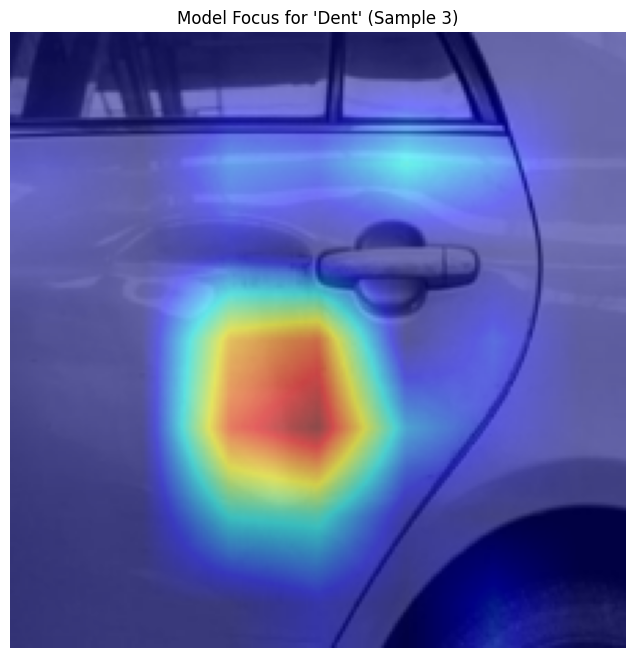

In [35]:
# --- RUN THIS AFTER DEFINING THE FUNCTION ABOVE ---
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 1. Select a specific sample index
SAMPLE_IDX = 3

# 2. Get the tensor from the dataset
image_tensor, label_tensor = val_dataset[SAMPLE_IDX]

# 3. Prepare input for model (Batch size 1)
input_tensor = image_tensor.unsqueeze(0).to(device)

# 4. Get the original raw image for visualization
raw_image_path = val_df.iloc[SAMPLE_IDX]['image_path']
rgb_img = np.array(Image.open(raw_image_path).resize((224, 224)))

# 5. Run Grad-CAM
# Target Index: 0=Glass, 1=Dent, 2=Scratch, 3=Wreck (Check your CLASS_NAMES order)
heatmap = visualize_damage_focus(
    model=model, 
    input_tensor=input_tensor, 
    rgb_img=rgb_img, 
    target_class_index=1
)

# 6. Display
plt.figure(figsize=(8, 8))
plt.imshow(heatmap)
plt.title(f"Model Focus for 'Dent' (Sample {SAMPLE_IDX})")
plt.axis('off')
plt.show()

In [36]:
import torch
from torchvision import transforms, models
from PIL import Image

# 1. Setup Device and Class Names
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['Broken Glass', 'Dent', 'Scratch', 'Wreck']

# 2. Load Model Structure & Weights
weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1
model = models.convnext_tiny(weights=None)
model.classifier[2] = torch.nn.Linear(model.classifier[2].in_features, 4)
model.load_state_dict(torch.load("../results/final_finetuned_model.pth"))
model.to(device)
model.eval()

# 3. Define the Transform (Same as validation)
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 4. Predict Function
def predict_image(image_path, threshold=0.5):
    img = Image.open(image_path).convert('RGB')
    input_tensor = inference_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.sigmoid(output).squeeze()
        
    results = {}
    for idx, prob in enumerate(probs):
        results[class_names[idx]] = prob.item()
        
    detected = [name for name, prob in results.items() if prob > threshold]
    print(f"Detected Damages: {detected}")
    return results

# Example Usage:
# predict_image("path/to/crashed_car.jpg")

C:\Users\taimo\AppData\Local\Temp\ipykernel_2576\3000340099.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../results/final_finetuned

In [38]:
# 2. CALL the function (The Action)
# Notice the quotes " " around the path!
predict_image("C:/Users/taimo/Downloads/image23.jpg")

Detected Damages: ['Dent']


{'Broken Glass': 2.8999019852093966e-10,
 'Dent': 1.0,
 'Scratch': 2.1364645363064483e-05,
 'Wreck': 1.8201867790779147e-09}